# Occupancy Detection - Spinlab + AirQ

The aim of this notebook is to explain the power of automated feature engineering with a relational learning approach on multivariate time series data. Therefore different approaches for creating features are chosen and compared regarding their performance.

Summary:

- Prediction type: __Binary classification__
- Domain: __Energy__
- Prediction target: __Room occupancy__ 
- Source data: __1 tables, 19k rows__
- Population size: __19k__

_Author: Julian Oestreich_

The goal of this work is straight forward. Based on sensordata we want to predict wether the room is vacant or not.



# 1. Tracking Memory Consumption

A major issue of automated feature engineering is memory consumption. We would therefore like to be able to measure the memory consumption of different algorithms.

We will do so by tracking the overall system memory usage and then substracting the peak system memory usage from the initial memory usage. This gives a good approximation as long as we do not start any other memory-heavy processes while training.

In [1]:
import threading
import psutil
import time

In [2]:
class MemoryTracker():
    """
    The MemoryTracker measures the system's memory consumption
    once every second. It can be used to get an approximation of 
    the overall memory consumption of certain algorithms.
    """
    
    def __init__(self):
        self._initial_usage = 0
        self._max_usage = 0
        
        self._stop = False
        
        self.lock = threading.Lock()
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
    def __del__(self):
        self.stop()
        
    def _get_memory_usage(self):
        return psutil.virtual_memory().used

    def _measure_memory_usage(self):
        while True:
            time.sleep(1)
            
            self.lock.acquire()
                                    
            if self._stop:
                self.lock.release()
                break
            
            current_usage = self._get_memory_usage()
            
            if current_usage > self._max_usage:
                self._max_usage = current_usage
            
            self.lock.release()

    @property
    def peak_consumption(self):
        """
        The peak system memory consumption, in GB
        """
        self.lock.acquire()
        
        p_con = self._max_usage - self._initial_usage
        
        self.lock.release()
        
        p_con /= 1e9
        
        return p_con
    
    def start(self):
        """
        Starts measuring the memory consumption.
        """
        self.lock.acquire()
        
        self._initial_usage = self._get_memory_usage()
        
        self._max_usage = self._initial_usage
        
        self._stop = False
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
        self.th.start()
        
        self.lock.release()
        
    def stop(self):
        """
        Stops measuring the memory consumption.
        """
        self.lock.acquire()
        self._stop = True
        self.lock.release()

In [3]:
memory_tracker = MemoryTracker()

# 2. Prepare the data

Let's start our analysis by taking a closer look at our data. 

The first step is importing the relevant libraries and loading our CSV-Data into a Pandas Dataframe, which we can inspect then.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline 

# import the dataset
spinlab = pd.read_csv("spinlab_dezember.csv")
airq = pd.read_csv("airq_converted.csv", delimiter=';')

# we also delete the motion_count variable from our dataset because it
# has only use as a target for regression
#spinlab = spinlab.drop('motion_count', axis=1)
spinlab

,timestamp,light,humidity,temperature,occupancy,motion_count
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,False,0
1,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,False,0
2,2020-12-13 17:03:50.869352,1.666667,39.200001,20.400000,False,0
3,2020-12-13 17:04:53.966675,1.666667,39.200001,20.400000,False,0
4,2020-12-13 17:05:54.555811,1.666667,39.200001,20.400000,False,0
...,...,...,...,...,...,...
22810,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,True,45
22811,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,True,45
22812,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,True,48
22813,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,True,48


In [5]:
airq.isnull().sum()

DateTime              0
timestamp             0
DeviceID              0
uptime                0
Status                0
measuretime           0
person                0
window_open           0
window_event          0
door_event            0
dHdt                  0
dCO2dt                0
TypPS                 0
bat                   0
bat_e                 0
health                0
performance           0
tvoc                  0
tvoc_e                0
co2                   0
co2_e                 0
oxygen            18413
oxygen_e          18413
co                    0
co_e                 21
o3                18413
o3_e              18413
pm1                   0
pm1_e                 0
pm2_5                 0
pm2_5_e               0
pm10                  0
pm10_e                0
cnt0_3                0
cnt0_3_e              0
cnt0_5                0
cnt0_5_e              0
cnt1                  0
cnt1_e                0
cnt2_5                0
cnt2_5_e              0
cnt5            

In [6]:
airq = airq.drop(['oxygen', 'oxygen_e', 'o3', 'o3_e', 'so2', 'so2_e'], axis=1)
airq.isnull().sum()

DateTime           0
timestamp          0
DeviceID           0
uptime             0
Status             0
measuretime        0
person             0
window_open        0
window_event       0
door_event         0
dHdt               0
dCO2dt             0
TypPS              0
bat                0
bat_e              0
health             0
performance        0
tvoc               0
tvoc_e             0
co2                0
co2_e              0
co                 0
co_e              21
pm1                0
pm1_e              0
pm2_5              0
pm2_5_e            0
pm10               0
pm10_e             0
cnt0_3             0
cnt0_3_e           0
cnt0_5             0
cnt0_5_e           0
cnt1               0
cnt1_e             0
cnt2_5             0
cnt2_5_e           0
cnt5               0
cnt5_e             0
cnt10              0
cnt10_e            0
temperature        0
temperature_e      0
humidity           0
humidity_e         0
humidity_abs       0
humidity_abs_e     0
dewpt        

Lets take a closer look at the different variables. DeviceID, uptime, Status are obviously not needed. We can delete them. 

There are also 3 different columns with informations regarding time. Lets inspect them.

In [7]:
airq[['DateTime', 'timestamp', 'measuretime']]

,DateTime,timestamp,measuretime
0,03.12.2020 16:44:02,1607010242000,"959,304"
1,03.12.2020 16:46:05,1607010365000,"988,746"
2,03.12.2020 16:51:19,1607010679000,"905,128"
3,03.12.2020 17:20:52,1607012452000,"1011,336"
4,03.12.2020 17:22:54,1607012574000,"914,8849"
...,...,...,...
18408,29.12.2020 14:44:54,1609249494000,"912,959"
18409,29.12.2020 14:46:55,1609249615000,"920,6719"
18410,29.12.2020 14:48:57,1609249737000,"911,742"
18411,29.12.2020 14:50:58,1609249858000,"927,403"


In [8]:
airq = airq.drop(['DeviceID', 'uptime', 'Status', 'measuretime', 'timestamp'], axis=1)

In [9]:
airq = airq[~airq['co'].str.contains("warm up")]
airq = airq[~airq['no2'].str.contains("warm up")]

In [10]:
airq['sound']

32       47,614 - 4,23
33       43,575 - 4,91
34        42,307 - 4,7
35       42,609 - 4,75
36       42,691 - 4,63
             ...      
18408    47,438 - 4,95
18409    47,308 - 5,25
18410    39,486 - 5,86
18411    39,113 - 5,75
18412    39,153 - 5,74
Name: sound, Length: 18376, dtype: object

In [11]:
#airq[['sound1', 'sound2']] = 
airq['sound1'] = airq['sound'].str.split('-').str[0].replace(',','.')
airq['sound2'] = airq['sound'].str.split('-').str[1].replace(',','.')
airq = airq.drop(['sound'], axis=1)

By taking a look at the datatypes of different columns we see that they are treated by pandas as objects so far. Thats because in the raw data komas were used for for punctuation. Let's change that by converting the komas back to points and then cast the string objects into float datatypes.

In [12]:
for column in airq.columns:
    if airq.dtypes[column] == 'object' and column != 'DateTime':
        airq[[column]] = airq[[column]].apply(lambda x: x.str.replace(',','.')).astype(float)
airq

,DateTime,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,bat_e,...,humidity_abs,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2
32,03.12.2020 18:22:48,0,0,0,0.0,-0.006,-23.910,0.623,0,0,...,6.099,0.56,3.862,1.4,987.5999,1.0,8.028,3.01,47.614,4.23
33,03.12.2020 18:24:49,0,0,0,0.0,-0.084,-18.560,0.604,0,0,...,6.100,0.56,3.864,1.4,987.6270,1.0,7.391,3.05,43.575,4.91
34,03.12.2020 18:26:51,0,0,0,0.0,-0.005,-18.867,0.598,0,0,...,6.093,0.56,3.847,1.4,987.6270,1.0,6.726,3.12,42.307,4.70
35,03.12.2020 18:28:51,0,1,0,0.0,-0.117,-61.431,0.590,0,0,...,6.078,0.56,3.812,1.4,987.6120,1.0,6.412,3.11,42.609,4.75
36,03.12.2020 18:30:52,0,0,0,0.0,0.029,-18.763,0.605,0,0,...,6.103,0.56,3.870,1.4,987.5990,1.0,6.604,3.11,42.691,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18408,29.12.2020 14:44:54,0,0,0,0.0,0.052,-0.932,0.537,0,0,...,6.610,0.50,4.952,1.1,976.5269,1.0,7.486,3.01,47.438,4.95
18409,29.12.2020 14:46:55,0,0,0,0.0,0.045,18.428,0.518,0,0,...,6.630,0.50,4.996,1.1,976.5880,1.0,7.366,3.01,47.308,5.25
18410,29.12.2020 14:48:57,1,0,0,0.0,0.163,59.803,0.513,0,0,...,6.636,0.50,5.008,1.1,976.6410,1.0,7.866,3.02,39.486,5.86
18411,29.12.2020 14:50:58,0,0,0,0.0,-0.053,-10.693,0.632,0,0,...,6.626,0.50,4.987,1.1,976.6859,1.0,8.319,3.01,39.113,5.75


In [13]:
import datetime
def dateOrNotToDate(date_str):
    return  datetime.datetime.strptime(date_str, '%d.%m.%Y %H:%M:%S')

In [14]:
def convert_dates(df):
    for i, date in enumerate(df['DateTime']):
        df.iloc[i, df.columns.get_loc('DateTime')] = dateOrNotToDate(date)

In [15]:
convert_dates(airq)

In [16]:
airq = airq.rename(columns={"DateTime": "date"})
spinlab = spinlab.rename(columns={'timestamp': 'date'})

In [17]:
spinlab['occupancy'] = spinlab[['occupancy']].astype(int)
spinlab = spinlab.drop(['motion_count'], axis=1)

In [18]:
airq_train = airq[:int(len(airq)*0.7)]
airq_test = airq[int(len(airq)*0.7):]

spinlab_train = spinlab[:int(len(spinlab)*0.7)]
spinlab_test = spinlab[int(len(spinlab)*0.7):]

airq_train_getml = airq_train.copy()
airq_test_getml = airq_test.copy()
airq_train_ts = airq_train.copy()
airq_test_ts = airq_test.copy()
airq_train_ft = airq_train.copy()
airq_test_ft = airq_test.copy()

spinlab_train_getml = spinlab_train.copy()
spinlab_test_getml = spinlab_test.copy()
spinlab_train_ts = spinlab_train.copy()
spinlab_test_ts = spinlab_test.copy()
spinlab_train_ft = spinlab_train.copy()
spinlab_test_ft = spinlab_test.copy()

In [19]:
spinlab_train.describe()

,light,humidity,temperature,occupancy
count,15970.000000,15970.000000,15970.000000,15970.000000
mean,17.710447,40.165905,20.727777,0.219912
std,25.202917,1.400834,0.342377,0.414200
min,0.833333,35.599998,19.299999,0.000000
25%,1.666667,39.299999,20.500000,0.000000
50%,1.666667,40.099998,20.799999,0.000000
75%,55.833333,40.599998,21.000000,0.000000
max,66.666667,45.099998,21.299999,1.000000


In [20]:
spinlab_test.describe()

,light,humidity,temperature,occupancy
count,6845.000000,6845.000000,6845.000000,6845.000000
mean,11.903701,39.962045,20.343214,0.091892
std,33.054480,1.372283,0.367109,0.288894
min,0.000000,34.400002,19.200001,0.000000
25%,1.666667,38.900002,20.100000,0.000000
50%,1.666667,40.200001,20.299999,0.000000
75%,4.166667,41.000000,20.600000,0.000000
max,203.333333,42.700001,21.000000,1.000000


# 3. Automated Feature Engineering with getML

In [21]:
import getml
                        
getml.engine.set_project('occupancy_airq_december')

Loading existing project 'occupancy_airq_december'


In [22]:
spinlab_train_getml = getml.data.DataFrame.from_pandas(spinlab_train_getml, "spinlab_train_getml")
spinlab_test_getml = getml.data.DataFrame.from_pandas(spinlab_test_getml, "spinlab_test_getml")

airq_train_getml = getml.data.DataFrame.from_pandas(airq_train_getml, "airq_train_getml")
airq_test_getml = getml.data.DataFrame.from_pandas(airq_test_getml, "airq_test_getml")

In [23]:
spinlab_test_getml

Name,light,humidity,temperature,occupancy,date
Role,unused_float,unused_float,unused_float,unused_float,unused_string
0,1.66667,41.7,21,0,2020-12-24 21:53:07.023227
1,1.66667,41.7,21,0,2020-12-24 21:54:07.567824
2,1.66667,41.6,20.9,0,2020-12-24 21:55:08.111206
3,1.66667,41.6,20.9,0,2020-12-24 21:56:08.700286
4,1.66667,41.6,20.9,0,2020-12-24 21:57:09.289343
,...,...,...,...,...
6840,188.333,35.1,20.4,1,2020-12-29 17:14:14.611352
6841,188.333,35.2,20.3,1,2020-12-29 17:15:15.200585
6842,188.333,35.3,20.3,1,2020-12-29 17:16:15.789912


In [24]:
for df in [spinlab_test_getml, spinlab_train_getml]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role("date", getml.data.roles.time_stamp, time_formats=['%Y-%m-%d %H:%M:%S.%F'])
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [25]:
spinlab_test_getml

Name,date,occupancy,light,humidity,temperature
Role,time_stamp,target,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,
0,2020-12-24T21:53:07.023227Z,0,1.66667,41.7,21
1,2020-12-24T21:54:07.567824Z,0,1.66667,41.7,21
2,2020-12-24T21:55:08.111206Z,0,1.66667,41.6,20.9
3,2020-12-24T21:56:08.700286Z,0,1.66667,41.6,20.9
4,2020-12-24T21:57:09.289343Z,0,1.66667,41.6,20.9
,...,...,...,...,...
6840,2020-12-29T17:14:14.611352Z,1,188.333,35.1,20.4
6841,2020-12-29T17:15:15.200585Z,1,188.333,35.2,20.3


In [26]:
for df in [airq_test_getml, airq_train_getml]:
    df.set_role("date", getml.data.roles.time_stamp, time_formats=['%Y-%m-%d %H:%M:%S'])
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [27]:
airq_test_getml

Name,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,bat_e,health,performance,tvoc,tvoc_e,co2,co2_e,co,co_e,pm1,pm1_e,pm2_5,pm2_5_e,pm10,pm10_e,cnt0_3,cnt0_3_e,cnt0_5,cnt0_5_e,cnt1,cnt1_e,cnt2_5,cnt2_5_e,cnt5,cnt5_e,cnt10,cnt10_e,temperature,temperature_e,humidity,humidity_e,humidity_abs,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2
Role,time_stamp,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2020-12-21T20:45:19.000000Z,0,0,0,0,0,-13.47,0.524,0,0,551.595,741.119,1263.95,200.32,543.157,66.65,1.065,0.2,0,10,0.099,10.03,0.124,10.04,129.446,27,40.223,15.27,1.661,10.22,0,10,0,10,0,10,18.899,0.63,43.37,3.86,7.054,0.5,5.885,1.1,1003.03,1,8.245,3.01,39.242,5.71
1,2020-12-21T20:47:20.000000Z,0,0,0,0,0,5.084,0.573,0,0,552.808,738.305,1260.39,199.83,547.325,66.76,1.065,0.2,0.1,10.03,0.1,10.03,0.308,10.06,151.8,29.97,46.225,16.08,2.2,10.37,0.425,10.1,0.425,10.1,0,10,18.899,0.63,43.37,3.86,7.054,0.5,5.885,1.1,1002.93,1,8.164,3.01,39.349,5.67
2,2020-12-21T20:49:21.000000Z,0,0,0,0,0,-15.726,0.515,0,0,552.483,743.28,1261.47,199.92,541.25,66.67,1.065,0.2,0,10,0,10,0.033,10.02,140.25,28.24,41.6,15.39,1.4,10.16,0,10,0,10,0,10,18.898,0.63,43.37,3.86,7.054,0.5,5.884,1.1,1002.86,1,8.208,3.01,39.189,5.72
3,2020-12-21T20:51:23.000000Z,0,0,0,0,0,1.071,0.656,0,0,552.802,739.574,1260.24,199.78,545.909,66.69,1.065,0.2,0,10,0.107,10.03,0.306,10.05,160.289,30.25,47.612,16.14,3.438,10.75,0.421,10.1,0.421,10.1,0.421,10.1,18.9,0.63,43.37,3.86,7.054,0.5,5.886,1.1,1002.81,1,8.264,3,39.293,5.68
4,2020-12-21T20:53:24.000000Z,1,0,0,0,0.002,23.135,0.547,0,0,550.333,737.868,1267.41,201.12,546.092,66.72,1.065,0.2,0.117,10.03,0.133,10.03,0.367,10.06,175.65,33.68,57.4,17.72,1.725,10.33,0.45,10.1,0.45,10.1,0,10,18.899,0.63,43.37,3.86,7.054,0.5,5.885,1.1,1002.71,1,8.133,3.01,39.514,5.62
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5508,2020-12-29T14:44:54.000000Z,0,0,0,0,0.052,-0.932,0.537,0,0,496.488,756.677,1431.43,233.37,480.829,64.77,0.91,0.17,0.431,10.05,0.683,10.05,0.683,10.05,235.854,38.87,73.089,18.97,5.65,10.97,0,10,0,10,0,10,18.733,0.63,41.044,3.88,6.61,0.5,4.952,1.1,976.527,1,7.486,3.01,47.438,4.95
5509,2020-12-29T14:46:55.000000Z,0,0,0,0,0.045,18.428,0.518,0,0,426.63,705.34,1658.24,278.14,485.908,65.38,0.911,0.17,0.756,10.08,0.899,10.08,0.899,10.08,292.109,48.21,89.941,21.74,3.429,10.55,0,10,0,10,0,10,18.723,0.63,41.195,3.88,6.63,0.5,4.996,1.1,976.588,1,7.366,3.01,47.308,5.25


In [28]:
airq_train

,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,bat_e,...,humidity_abs,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2
32,2020-12-03 18:22:48,0,0,0,0.0,-0.006,-23.910,0.623,0,0,...,6.099,0.56,3.862,1.4,987.5999,1.0,8.028,3.01,47.614,4.23
33,2020-12-03 18:24:49,0,0,0,0.0,-0.084,-18.560,0.604,0,0,...,6.100,0.56,3.864,1.4,987.6270,1.0,7.391,3.05,43.575,4.91
34,2020-12-03 18:26:51,0,0,0,0.0,-0.005,-18.867,0.598,0,0,...,6.093,0.56,3.847,1.4,987.6270,1.0,6.726,3.12,42.307,4.70
35,2020-12-03 18:28:51,0,1,0,0.0,-0.117,-61.431,0.590,0,0,...,6.078,0.56,3.812,1.4,987.6120,1.0,6.412,3.11,42.609,4.75
36,2020-12-03 18:30:52,0,0,0,0.0,0.029,-18.763,0.605,0,0,...,6.103,0.56,3.870,1.4,987.5990,1.0,6.604,3.11,42.691,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12894,2020-12-21 20:35:11,0,0,0,0.0,-0.010,7.396,0.578,0,0,...,7.055,0.50,5.887,1.1,1003.0490,1.0,7.858,3.01,39.799,5.82
12895,2020-12-21 20:37:13,0,0,0,0.0,-0.010,-13.034,0.549,0,0,...,7.054,0.50,5.884,1.1,1003.0450,1.0,7.842,3.01,39.338,5.67
12896,2020-12-21 20:39:14,0,0,0,0.0,-0.001,12.217,0.539,0,0,...,7.054,0.50,5.886,1.1,1003.0670,1.0,7.957,3.01,39.339,5.67
12897,2020-12-21 20:41:16,0,0,0,0.0,0.000,4.277,0.562,0,0,...,7.054,0.50,5.885,1.1,1003.1400,1.0,8.104,3.01,39.333,5.67


In [29]:
population = getml.data.Placeholder('population')

peripheral_spinlab = getml.data.Placeholder('peripheral_spinlab')

peripheral_airq = getml.data.Placeholder('peripheral_airq')


# 1. The horizon is 0 (we do not predict future data). 
# 2. The memory is 30 mins, so we allow the algorithm to 
#    use information from up to 30 minutes ago. 

population.join(
    peripheral_spinlab,
    time_stamp='date',
    horizon=getml.data.time.hours(0),
    memory=getml.data.time.minutes(30)
)

population.join(
    peripheral_airq,
    time_stamp='date',
    horizon=getml.data.time.hours(0),
    memory=getml.data.time.minutes(30)
)

population

placeholder    other placeholder   allow lagged targets   horizon   
population    peripheral_spinlab   False                  0.0       
population    peripheral_airq      False                  0.0       



join keys used   memory   other join keys used   other time stamps used   
                 1800.0                          date                     
                 1800.0                          date                     



join keys used   relationship   time stamps used   ...   
                 many-to-many   date               ...   
                 many-to-many   date               ...

In [30]:
#multirel = getml.feature_learning.MultirelModel(
#    num_features=10,
#    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
#    seed=4367,
#    num_threads=6
#)

relboost = getml.feature_learning.RelboostModel(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss
)

predictor = getml.predictors.LogisticRegression()

In [31]:
seasonal = getml.preprocessors.Seasonal()
imputer = getml.preprocessors.Imputation()
pipe = getml.pipeline.Pipeline(
    tags=['memory: 30m', 'horizon: 0m', 'relboost'],
    population=population,
    peripheral=[peripheral_spinlab, peripheral_airq],
    feature_learners=[relboost],
    preprocessors=[seasonal, imputer],
    predictors=[predictor]
)

In [32]:
spinlab_train_getml 

Name,date,occupancy,light,humidity,temperature
Role,time_stamp,target,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,
0,2020-12-13T17:01:49.691047Z,0,1.66667,39.2,20.4
1,2020-12-13T17:02:50.280221Z,0,1.66667,39.2,20.4
2,2020-12-13T17:03:50.869352Z,0,1.66667,39.2,20.4
3,2020-12-13T17:04:53.966675Z,0,1.66667,39.2,20.4
4,2020-12-13T17:05:54.555811Z,0,1.66667,39.2,20.4
,...,...,...,...,...
15965,2020-12-24T21:48:04.102119Z,0,1.66667,41.6,20.9
15966,2020-12-24T21:49:04.691289Z,0,1.66667,41.6,20.9


In [33]:
start = time.time()
memory_tracker.start()

pipe.fit(spinlab_train_getml, [spinlab_train_getml, airq_train_getml])

memory_tracker.stop()
end=time.time()

print("Elapsed Time:")
print(end-start)

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

Checking data model...


WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'COALESCE( window_event, 0.000000 )' in  data frame 'peripheral_airq' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'COALESCE( door_event, 0.000000 )' in  data frame 'peripheral_airq' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'COALESCE( bat, 0.000000 )' in  data frame 'peripheral_airq' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL 


Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:2m:58.380841

Elapsed Time:
180.17202019691467
Memory consumption: 
0.13965312


In [34]:
in_sample = pipe.score(spinlab_train_getml, [spinlab_train_getml, airq_train_getml])

out_of_sample = pipe.score(spinlab_test_getml, [spinlab_test_getml, airq_test_getml])

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


Relboost: Building features...
[========================================] 100%


Relboost: Building features...
[========================================] 100%


Accuracy (training): 0.87113
AUC (training): 0.92158

Accuracy (testing): 0.90825
AUC (testing): 0.60661



In [35]:
out_of_sample 

{'accuracy': [0.908254200146092],
 'auc': [0.6066140663716179],
 'cross_entropy': [1.1548636235934446]}

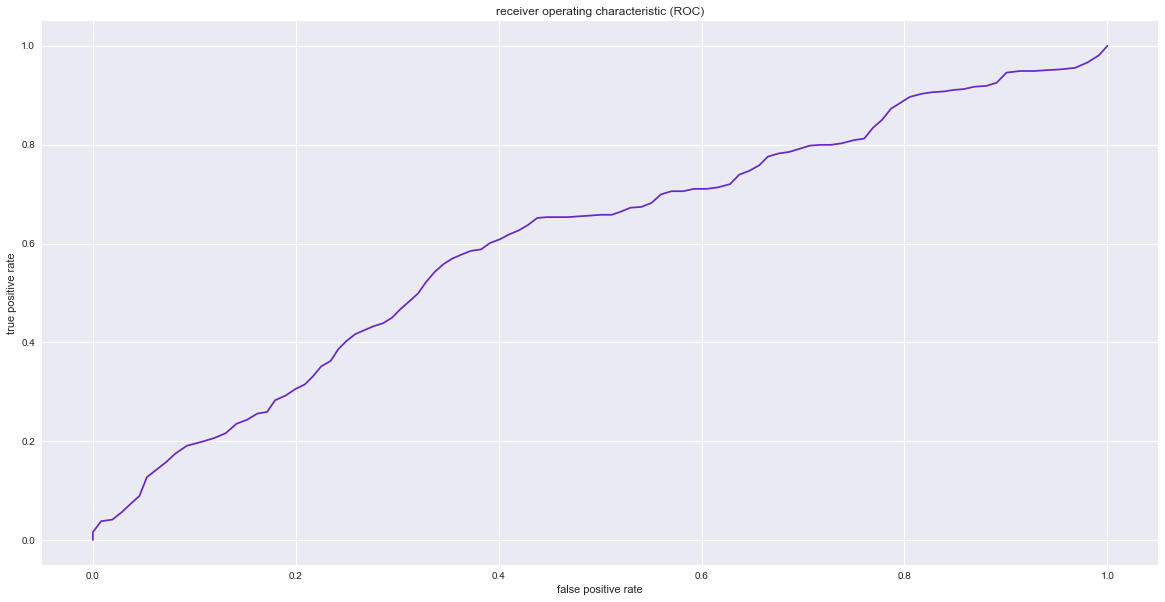

In [38]:
# Refers to the data from the last time
# we called .score(...).
fpr_g, tpr_g = pipe.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_g, tpr_g, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

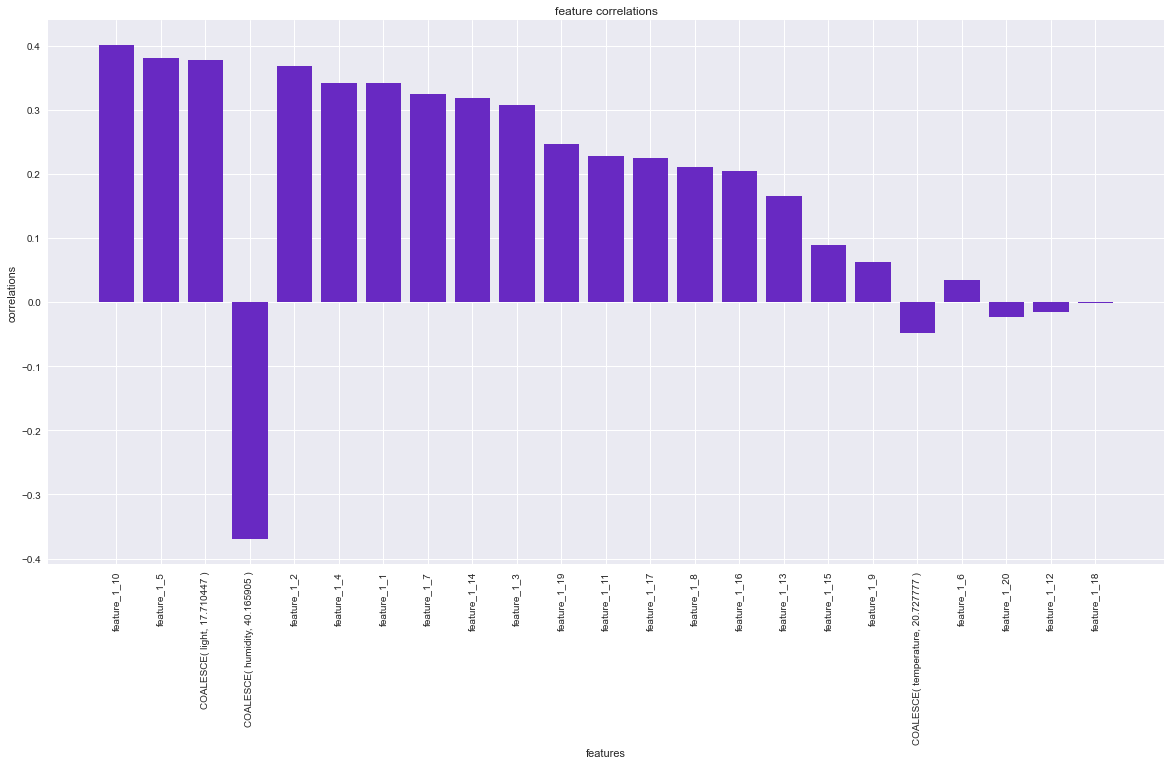

In [39]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

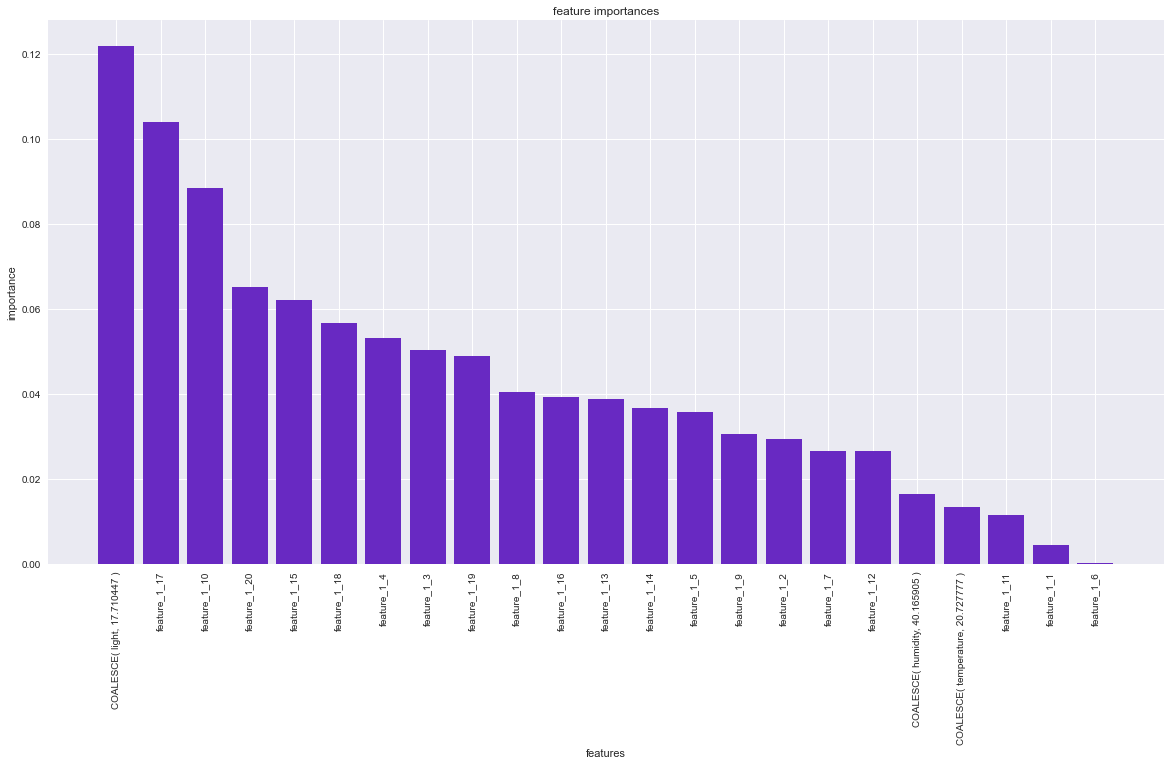

In [40]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [51]:
pipe.features.to_sql()[names[1]] 

```sql
DROP TABLE IF EXISTS "FEATURE_1_17";

CREATE TABLE "FEATURE_1_17" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( t2."light", 17.710447 ) > 7.392814 ) AND ( strftime('%H', t1."date" ) IN ( '17', '18', '20', '21', '06', '07', '08', '10', '12', '13', '14' ) ) AND ( strftime('%H', t2."date" ) IN ( '06', '09', '16' ) ) THEN -1.314113384394459
        WHEN ( COALESCE( t2."light", 17.710447 ) > 7.392814 ) AND ( strftime('%H', t1."date" ) IN ( '17', '18', '20', '21', '06', '07', '08', '10', '12', '13', '14' ) ) AND ( strftime('%H', t2."date" ) NOT IN ( '06', '09', '16' ) ) THEN 0.4876481886097215
        WHEN ( COALESCE( t2."light", 17.710447 ) > 7.392814 ) AND ( strftime('%H', t1."date" ) NOT IN ( '17', '18', '20', '21', '06', '07', '08', '10', '12', '13', '14' ) ) AND ( COALESCE( t1."humidity", 40.165905 ) > 39.280347 ) THEN 1.28610252970123
        WHEN ( COALESCE( t2."light", 17.710447 ) > 7.392814 ) AND ( strftime('%H', t1."date" ) NOT IN ( '17', '18', '20', '21', '06', '07', '08', '10', '12', '13', '14' ) ) AND ( COALESCE( t1."humidity", 40.165905 ) <= 39.280347 OR COALESCE( t1."humidity", 40.165905 ) IS NULL ) THEN 0.6509041845249638
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 7.392814 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%w', t2."date" ) IN ( '0', '4', '6' ) ) AND ( strftime('%H', t1."date" ) IN ( '17', '18', '19', '20', '22', '00', '01', '04', '05', '07', '08', '09', '10', '11', '12', '14', '15', '16' ) ) THEN -0.8645731850720432
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 7.392814 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%w', t2."date" ) IN ( '0', '4', '6' ) ) AND ( strftime('%H', t1."date" ) NOT IN ( '17', '18', '19', '20', '22', '00', '01', '04', '05', '07', '08', '09', '10', '11', '12', '14', '15', '16' ) ) THEN 0.1407280625842316
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 7.392814 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%w', t2."date" ) NOT IN ( '0', '4', '6' ) ) AND ( COALESCE( t1."light", 17.710447 ) > 2.314815 ) THEN 0.8971464049585272
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 7.392814 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%w', t2."date" ) NOT IN ( '0', '4', '6' ) ) AND ( COALESCE( t1."light", 17.710447 ) <= 2.314815 OR COALESCE( t1."light", 17.710447 ) IS NULL ) THEN -0.1550338698356503
        ELSE NULL
    END
) AS "feature_1_17",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral_spinlab" t2
ON 1 = 1
WHERE julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
GROUP BY t1.rowid;
```

In [52]:
pipe.features.to_sql()[names[2]] 

```sql
DROP TABLE IF EXISTS "FEATURE_1_10";

CREATE TABLE "FEATURE_1_10" AS
SELECT SUM( 
    CASE
        WHEN ( COALESCE( t2."light", 17.710447 ) > 9.963504 ) AND ( COALESCE( t1."light", 17.710447 ) > 54.839744 ) AND ( julianday( t1."date" ) > julianday( t2."date", '+56.920041 seconds' ) ) THEN 0.01073259837575055
        WHEN ( COALESCE( t2."light", 17.710447 ) > 9.963504 ) AND ( COALESCE( t1."light", 17.710447 ) > 54.839744 ) AND ( julianday( t1."date" ) <= julianday( t2."date", '+56.920041 seconds' ) OR julianday( t1."date" ) IS NULL OR julianday( t2."date", '+56.920041 seconds' ) IS NULL ) THEN 1.764262180570775
        WHEN ( COALESCE( t2."light", 17.710447 ) > 9.963504 ) AND ( COALESCE( t1."light", 17.710447 ) <= 54.839744 OR COALESCE( t1."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) IN ( '20' ) ) THEN 2.133276861952439
        WHEN ( COALESCE( t2."light", 17.710447 ) > 9.963504 ) AND ( COALESCE( t1."light", 17.710447 ) <= 54.839744 OR COALESCE( t1."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) NOT IN ( '20' ) ) THEN 0.1361205911719612
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 9.963504 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) IN ( '17', '18', '19', '20', '21', '22', '02', '04', '05', '06', '07', '10', '14', '15', '16' ) ) AND ( COALESCE( t2."humidity", 40.165905 ) > 38.283818 ) THEN 0.02181931377880313
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 9.963504 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) IN ( '17', '18', '19', '20', '21', '22', '02', '04', '05', '06', '07', '10', '14', '15', '16' ) ) AND ( COALESCE( t2."humidity", 40.165905 ) <= 38.283818 OR COALESCE( t2."humidity", 40.165905 ) IS NULL ) THEN 0.1131474913698819
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 9.963504 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) NOT IN ( '17', '18', '19', '20', '21', '22', '02', '04', '05', '06', '07', '10', '14', '15', '16' ) ) AND ( strftime('%w', t1."date" ) IN ( '3' ) ) THEN 0.07336849421137898
        WHEN ( COALESCE( t2."light", 17.710447 ) <= 9.963504 OR COALESCE( t2."light", 17.710447 ) IS NULL ) AND ( strftime('%H', t2."date" ) NOT IN ( '17', '18', '19', '20', '21', '22', '02', '04', '05', '06', '07', '10', '14', '15', '16' ) ) AND ( strftime('%w', t1."date" ) NOT IN ( '3' ) ) THEN 0.03791428815339198
        ELSE NULL
    END
) AS "feature_1_10",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral_spinlab" t2
ON 1 = 1
WHERE julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
GROUP BY t1.rowid;
```

In [53]:
pipe.features.to_sql()[names[3]] 

```sql
DROP TABLE IF EXISTS "FEATURE_1_20";

CREATE TABLE "FEATURE_1_20" AS
SELECT SUM( 
    CASE
        WHEN ( strftime('%H', t2."date" ) IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."cnt2_5_e", 10.238933 ) > 10.378621 ) AND ( COALESCE( t1."humidity", 40.165905 ) > 40.702701 ) THEN 7.665474711708879
        WHEN ( strftime('%H', t2."date" ) IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."cnt2_5_e", 10.238933 ) > 10.378621 ) AND ( COALESCE( t1."humidity", 40.165905 ) <= 40.702701 OR COALESCE( t1."humidity", 40.165905 ) IS NULL ) THEN 0.1647456814939712
        WHEN ( strftime('%H', t2."date" ) IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."cnt2_5_e", 10.238933 ) <= 10.378621 OR COALESCE( t2."cnt2_5_e", 10.238933 ) IS NULL ) AND ( strftime('%M', t2."date" ) IN ( '22', '00', '01', '02', '04', '05', '08', '10', '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59' ) ) THEN -0.08022841399533284
        WHEN ( strftime('%H', t2."date" ) IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."cnt2_5_e", 10.238933 ) <= 10.378621 OR COALESCE( t2."cnt2_5_e", 10.238933 ) IS NULL ) AND ( strftime('%M', t2."date" ) NOT IN ( '22', '00', '01', '02', '04', '05', '08', '10', '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59' ) ) THEN 0.01677908587485145
        WHEN ( strftime('%H', t2."date" ) NOT IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."sound2", 5.212300 ) > 5.780690 ) AND ( strftime('%M', t1."date" ) IN ( '17', '18', '19', '20', '21', '22', '23', '06', '11', '12', '15', '16', '24', '25', '26', '27', '28', '31', '44', '45', '46', '48', '51', '52', '53', '54', '55', '56', '57', '58', '59' ) ) THEN -0.09357807273142395
        WHEN ( strftime('%H', t2."date" ) NOT IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."sound2", 5.212300 ) > 5.780690 ) AND ( strftime('%M', t1."date" ) NOT IN ( '17', '18', '19', '20', '21', '22', '23', '06', '11', '12', '15', '16', '24', '25', '26', '27', '28', '31', '44', '45', '46', '48', '51', '52', '53', '54', '55', '56', '57', '58', '59' ) ) THEN 0.8210837619376578
        WHEN ( strftime('%H', t2."date" ) NOT IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."sound2", 5.212300 ) <= 5.780690 OR COALESCE( t2."sound2", 5.212300 ) IS NULL ) AND ( COALESCE( t2."sound1", 41.983515 ) > 39.574911 ) THEN 0.02901801183721042
        WHEN ( strftime('%H', t2."date" ) NOT IN ( '18', '20', '21', '00', '02', '03', '04', '06', '09' ) ) AND ( COALESCE( t2."sound2", 5.212300 ) <= 5.780690 OR COALESCE( t2."sound2", 5.212300 ) IS NULL ) AND ( COALESCE( t2."sound1", 41.983515 ) <= 39.574911 OR COALESCE( t2."sound1", 41.983515 ) IS NULL ) THEN -0.04188434124547402
        ELSE NULL
    END
) AS "feature_1_20",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "peripheral_airq" t2
ON 1 = 1
WHERE julianday( t2."date" ) <= julianday( t1."date" )
AND ( julianday( t2."date", '+30.000000 minutes' ) > julianday( t1."date" ) OR julianday( t2."date", '+30.000000 minutes' ) IS NULL )
GROUP BY t1.rowid;
```

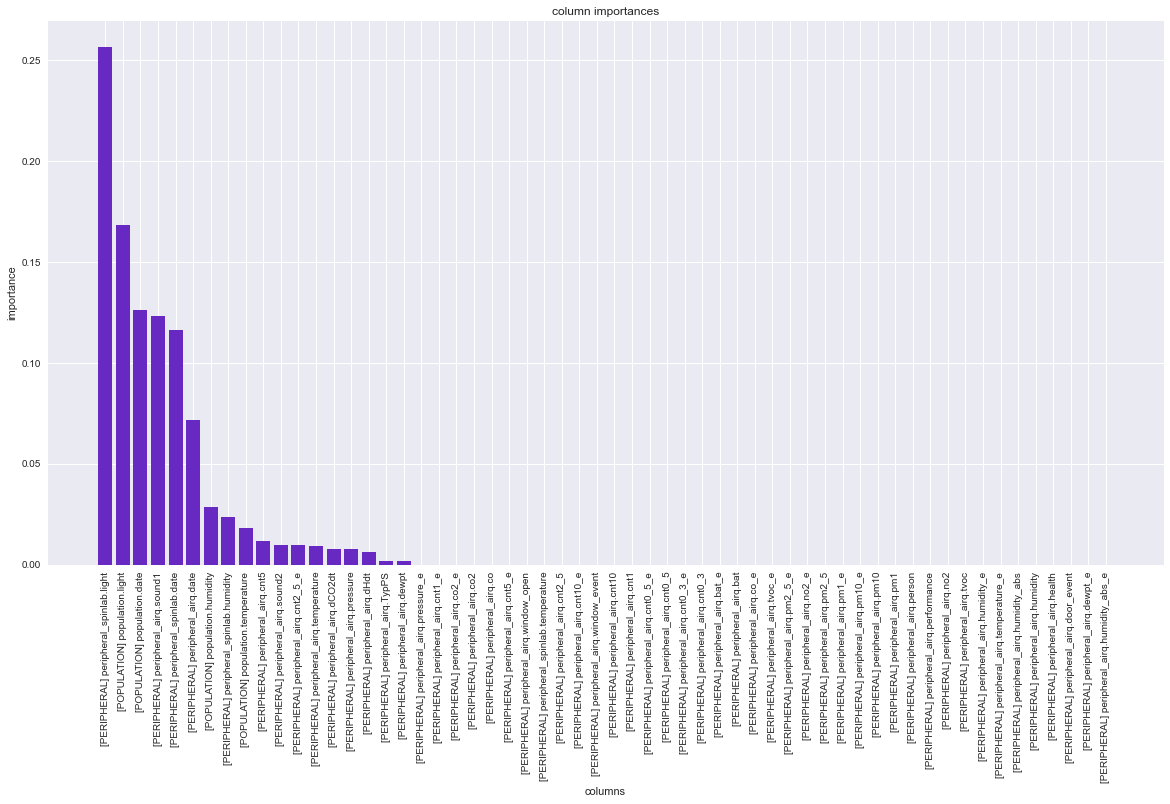

In [41]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [42]:
pipe.columns.select(
    spinlab_train_getml, 
    peripheral_tables=[spinlab_train_getml, airq_train_getml], 
    share_selected_columns=0.2
)



In [43]:
spinlab_train_getml

Name,date,occupancy,light,humidity,temperature
Role,time_stamp,target,numerical,numerical,unused_float
Unit,"time stamp, comparison only",,,,
0,2020-12-13T17:01:49.691047Z,0,1.66667,39.2,20.4
1,2020-12-13T17:02:50.280221Z,0,1.66667,39.2,20.4
2,2020-12-13T17:03:50.869352Z,0,1.66667,39.2,20.4
3,2020-12-13T17:04:53.966675Z,0,1.66667,39.2,20.4
4,2020-12-13T17:05:54.555811Z,0,1.66667,39.2,20.4
,...,...,...,...,...
15965,2020-12-24T21:48:04.102119Z,0,1.66667,41.6,20.9
15966,2020-12-24T21:49:04.691289Z,0,1.66667,41.6,20.9


In [44]:
relboost = getml.feature_learning.RelboostModel(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss
)

predictor = getml.predictors.LogisticRegression()

In [45]:
seasonal = getml.preprocessors.Seasonal()
imputer = getml.preprocessors.Imputation()
pipe2 = getml.pipeline.Pipeline(
    tags=['memory: 30m', 'horizon: 0m', 'relboost', 'columns-reduced'],
    population=population,
    peripheral=[peripheral_spinlab, peripheral_airq],
    feature_learners=[relboost],
    preprocessors=[seasonal, imputer],
    predictors=[predictor]
)

In [46]:
start = time.time()
memory_tracker.start()

pipe2.fit(spinlab_train_getml, [spinlab_train_getml, airq_train_getml])

memory_tracker.stop()
end=time.time()

print("Elapsed Time:")
print(end-start)

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

Checking data model...
OK.

Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:2m:23.950086

Elapsed Time:
145.7266228199005
Memory consumption: 
0.133951488


In [47]:
in_sample = pipe2.score(spinlab_train_getml, [spinlab_train_getml, airq_train_getml])


Relboost: Building features...
[========================================] 100%



In [48]:
out_of_sample = pipe2.score(spinlab_test_getml, [spinlab_test_getml, airq_test_getml])


Relboost: Building features...
[========================================] 100%



In [49]:
in_sample

{'accuracy': [0.8728866624921728],
 'auc': [0.9184657145046028],
 'cross_entropy': [0.29163744785307594]}

In [50]:
out_of_sample

{'accuracy': [0.908254200146092],
 'auc': [0.6598862517980075],
 'cross_entropy': [0.7369001693383849]}

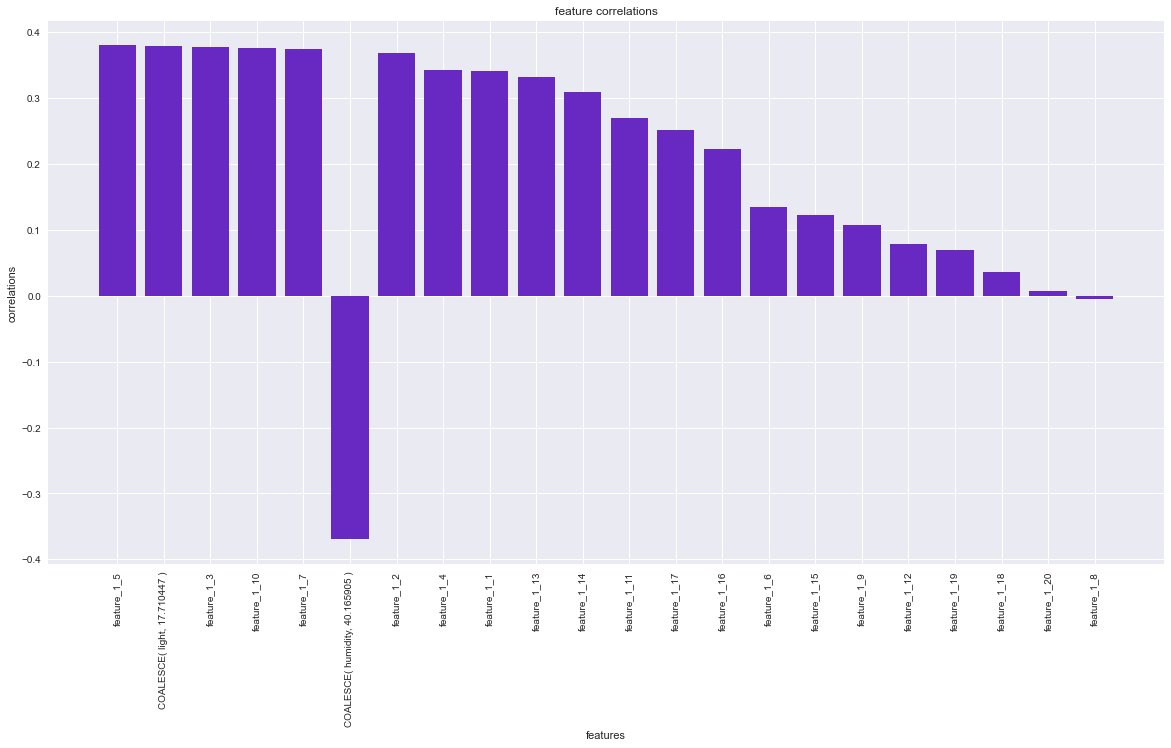

In [51]:
names, correlations = pipe2.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

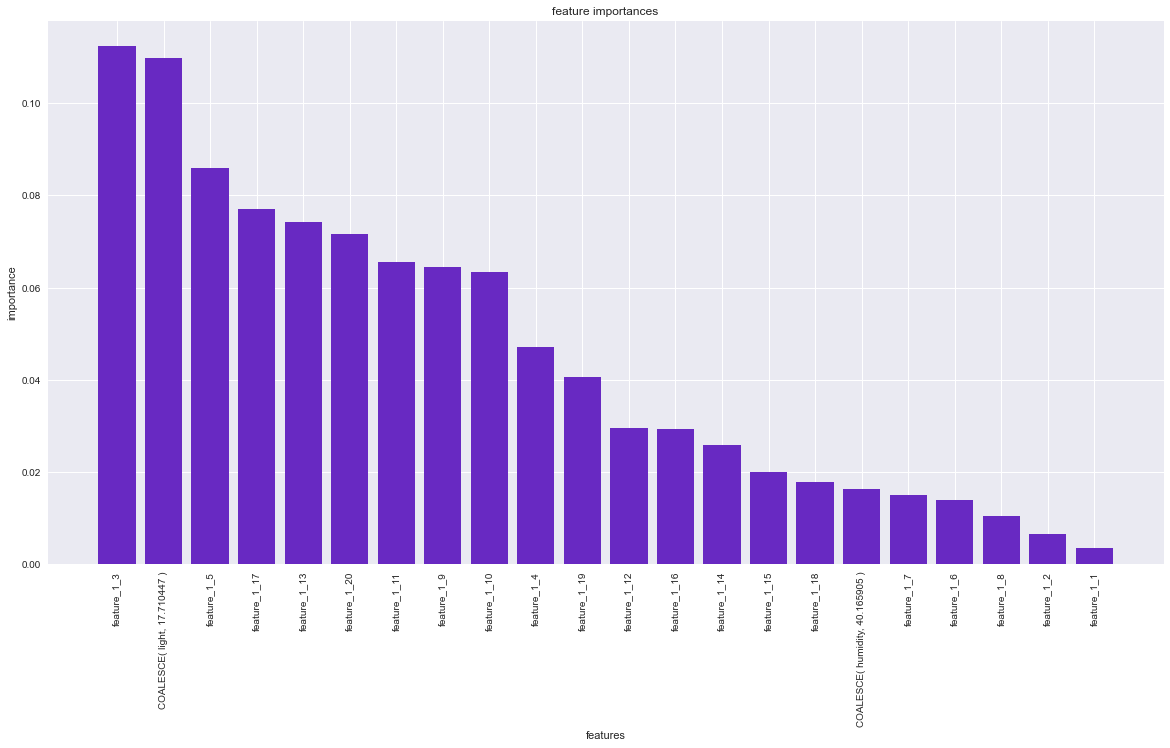

In [52]:
names, importances = pipe2.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

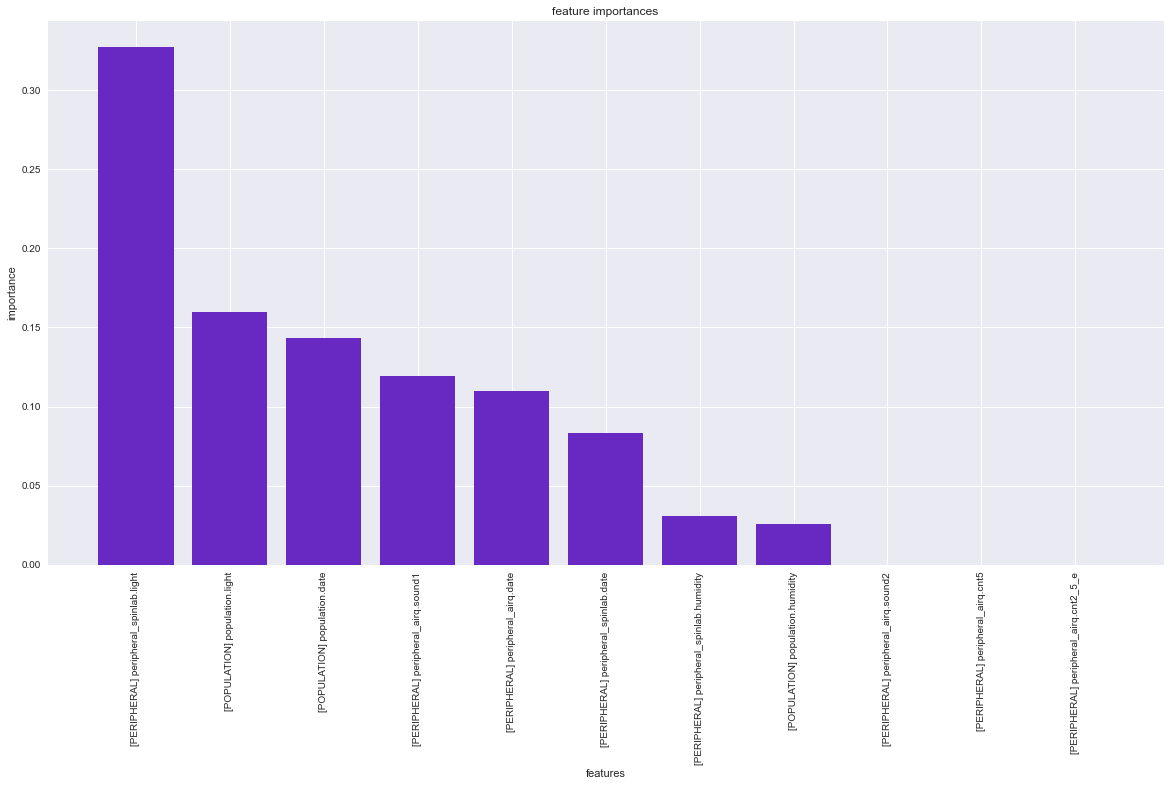

In [53]:
names, importances = pipe2.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

# 4. Automated Feature Engineering with Featuretools

Featuretools always requires a column with a unique id, which will be used as an index for the entity. Lets start by creating our index column 

In [54]:
spinlab['id'] = spinlab.index
spinlab

,date,light,humidity,temperature,occupancy,id
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0,0
1,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,0,1
2,2020-12-13 17:03:50.869352,1.666667,39.200001,20.400000,0,2
3,2020-12-13 17:04:53.966675,1.666667,39.200001,20.400000,0,3
4,2020-12-13 17:05:54.555811,1.666667,39.200001,20.400000,0,4
...,...,...,...,...,...,...
22810,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,1,22810
22811,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,1,22811
22812,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,1,22812
22813,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,1,22813


## 4.1 Create peripheral tables

First lets create a peripheral table to add the information to our datamodel how much of the past data we want to integrate in our features. We start by creating a a peripheral table for the spinlab, which is nothing else than the *self-join* in terms of getML

In [55]:
start = time.time()
memory_tracker.start()

spinlab_p = pd.DataFrame()

for index, row in spinlab.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = spinlab[(pd.to_datetime(spinlab['date']) >= until) & (pd.to_datetime(spinlab['date']) <= t)]
    to_add['join_key'] = int(row['id'])
    spinlab_p = spinlab_p.append(to_add)
    
end = time.time()
memory_tracker.stop()

print("Elapsed Time:")
print(end-start)

print("Memory consumption: ")
print(memory_tracker.peak_consumption)
    
spinlab_p

<ipython-input-55-291733564a43>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['id'])


Elapsed Time:
553.6342799663544
Memory consumption: 
0.631189504


,date,light,humidity,temperature,occupancy,id,join_key
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0,0,0
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0,0,1
1,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,0,1,1
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0,0,2
1,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,0,1,2
...,...,...,...,...,...,...,...
22810,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,1,22810,22814
22811,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,1,22811,22814
22812,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,1,22812,22814
22813,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,1,22813,22814


We see that the resulting table contains alot of redundant data which just differs in the join_key. Also we see that the id column is not unique anymore. Lets delete it and create a new one.

In [56]:
spinlab_p = spinlab_p.drop(['occupancy', 'id'], axis=1)
spinlab_p = spinlab_p.reset_index()
spinlab_p = spinlab_p.drop(['index'], axis=1)
spinlab_p = spinlab_p.reset_index()
spinlab_p

,index,date,light,humidity,temperature,join_key
0,0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0
1,1,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,1
2,2,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,1
3,3,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,2
4,4,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,2
...,...,...,...,...,...,...
683681,683681,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,22814
683682,683682,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,22814
683683,683683,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,22814
683684,683684,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,22814


The result is a table with a unique identifier and a join_key to define a relationship to the spinlab population table.

Let's continue by doing the same job for the AirQ Data

In [57]:
#airq
airq=airq.reset_index()
airq=airq.drop(['index'], axis=1)
airq=airq.reset_index()
airq

,index,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,...,humidity_abs,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2
0,0,2020-12-03 18:22:48,0,0,0,0.0,-0.006,-23.910,0.623,0,...,6.099,0.56,3.862,1.4,987.5999,1.0,8.028,3.01,47.614,4.23
1,1,2020-12-03 18:24:49,0,0,0,0.0,-0.084,-18.560,0.604,0,...,6.100,0.56,3.864,1.4,987.6270,1.0,7.391,3.05,43.575,4.91
2,2,2020-12-03 18:26:51,0,0,0,0.0,-0.005,-18.867,0.598,0,...,6.093,0.56,3.847,1.4,987.6270,1.0,6.726,3.12,42.307,4.70
3,3,2020-12-03 18:28:51,0,1,0,0.0,-0.117,-61.431,0.590,0,...,6.078,0.56,3.812,1.4,987.6120,1.0,6.412,3.11,42.609,4.75
4,4,2020-12-03 18:30:52,0,0,0,0.0,0.029,-18.763,0.605,0,...,6.103,0.56,3.870,1.4,987.5990,1.0,6.604,3.11,42.691,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18371,18371,2020-12-29 14:44:54,0,0,0,0.0,0.052,-0.932,0.537,0,...,6.610,0.50,4.952,1.1,976.5269,1.0,7.486,3.01,47.438,4.95
18372,18372,2020-12-29 14:46:55,0,0,0,0.0,0.045,18.428,0.518,0,...,6.630,0.50,4.996,1.1,976.5880,1.0,7.366,3.01,47.308,5.25
18373,18373,2020-12-29 14:48:57,1,0,0,0.0,0.163,59.803,0.513,0,...,6.636,0.50,5.008,1.1,976.6410,1.0,7.866,3.02,39.486,5.86
18374,18374,2020-12-29 14:50:58,0,0,0,0.0,-0.053,-10.693,0.632,0,...,6.626,0.50,4.987,1.1,976.6859,1.0,8.319,3.01,39.113,5.75


In [58]:
airq

,index,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,...,humidity_abs,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2
0,0,2020-12-03 18:22:48,0,0,0,0.0,-0.006,-23.910,0.623,0,...,6.099,0.56,3.862,1.4,987.5999,1.0,8.028,3.01,47.614,4.23
1,1,2020-12-03 18:24:49,0,0,0,0.0,-0.084,-18.560,0.604,0,...,6.100,0.56,3.864,1.4,987.6270,1.0,7.391,3.05,43.575,4.91
2,2,2020-12-03 18:26:51,0,0,0,0.0,-0.005,-18.867,0.598,0,...,6.093,0.56,3.847,1.4,987.6270,1.0,6.726,3.12,42.307,4.70
3,3,2020-12-03 18:28:51,0,1,0,0.0,-0.117,-61.431,0.590,0,...,6.078,0.56,3.812,1.4,987.6120,1.0,6.412,3.11,42.609,4.75
4,4,2020-12-03 18:30:52,0,0,0,0.0,0.029,-18.763,0.605,0,...,6.103,0.56,3.870,1.4,987.5990,1.0,6.604,3.11,42.691,4.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18371,18371,2020-12-29 14:44:54,0,0,0,0.0,0.052,-0.932,0.537,0,...,6.610,0.50,4.952,1.1,976.5269,1.0,7.486,3.01,47.438,4.95
18372,18372,2020-12-29 14:46:55,0,0,0,0.0,0.045,18.428,0.518,0,...,6.630,0.50,4.996,1.1,976.5880,1.0,7.366,3.01,47.308,5.25
18373,18373,2020-12-29 14:48:57,1,0,0,0.0,0.163,59.803,0.513,0,...,6.636,0.50,5.008,1.1,976.6410,1.0,7.866,3.02,39.486,5.86
18374,18374,2020-12-29 14:50:58,0,0,0,0.0,-0.053,-10.693,0.632,0,...,6.626,0.50,4.987,1.1,976.6859,1.0,8.319,3.01,39.113,5.75


In [59]:
spinlab

,date,light,humidity,temperature,occupancy,id
0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0,0
1,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,0,1
2,2020-12-13 17:03:50.869352,1.666667,39.200001,20.400000,0,2
3,2020-12-13 17:04:53.966675,1.666667,39.200001,20.400000,0,3
4,2020-12-13 17:05:54.555811,1.666667,39.200001,20.400000,0,4
...,...,...,...,...,...,...
22810,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,1,22810
22811,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,1,22811
22812,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,1,22812
22813,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,1,22813


In [60]:
start = time.time()
memory_tracker.start()

airq_p = pd.DataFrame()

for index, row in spinlab.iterrows():
    t = pd.to_datetime(row['date'])
    until = t - pd.Timedelta(minutes=30)
    to_add = airq[(pd.to_datetime(airq['date']) >= until) & (pd.to_datetime(airq['date']) <= t)]
    to_add['join_key'] = int(row['id'])
    airq_p = airq_p.append(to_add)
    
end = time.time()
memory_tracker.stop()

print("Elapsed Time:")
print(end-start)

print("Memory consumption: ")
print(memory_tracker.peak_consumption)
    
    
airq_p

<ipython-input-60-e4d145204702>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['id'])


Elapsed Time:
3538.602600336075
Memory consumption: 
0.428576768


,index,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,...,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2,join_key
7055,7055,2020-12-13 16:33:41,0,0,0,0.0,-0.000,-19.795,0.544,0,...,0.52,5.351,1.1,997.8120,1.0,8.258,3.01,40.913,5.19,0
7056,7056,2020-12-13 16:35:41,0,0,0,0.0,-0.007,10.380,0.628,0,...,0.52,5.350,1.1,997.8189,1.0,8.248,3.01,40.780,5.30,0
7057,7057,2020-12-13 16:37:43,0,0,0,0.0,0.000,7.738,0.603,0,...,0.52,5.348,1.1,997.8360,1.0,8.100,3.01,40.371,5.32,0
7058,7058,2020-12-13 16:39:45,0,0,0,0.0,-0.009,-0.790,0.572,0,...,0.52,5.346,1.1,997.8559,1.0,8.189,3.01,40.297,5.34,0
7059,7059,2020-12-13 16:41:46,0,0,0,0.0,0.002,-2.548,0.534,0,...,0.52,5.349,1.1,997.8840,1.0,8.388,3.01,40.404,5.31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,18375,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22696
18374,18374,2020-12-29 14:50:58,0,0,0,0.0,-0.053,-10.693,0.632,0,...,0.50,4.987,1.1,976.6859,1.0,8.319,3.01,39.113,5.75,22697
18375,18375,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22697
18375,18375,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22698


In [61]:
airq_p = airq_p.drop(['index'], axis=1)

In [62]:
airq_p=airq_p.reset_index()
airq_p=airq_p.drop(['index'], axis=1)
airq_p=airq_p.reset_index()

In [63]:
airq_p

,index,date,person,window_open,window_event,door_event,dHdt,dCO2dt,TypPS,bat,...,humidity_abs_e,dewpt,dewpt_e,pressure,pressure_e,no2,no2_e,sound1,sound2,join_key
0,0,2020-12-13 16:33:41,0,0,0,0.0,-0.000,-19.795,0.544,0,...,0.52,5.351,1.1,997.8120,1.0,8.258,3.01,40.913,5.19,0
1,1,2020-12-13 16:35:41,0,0,0,0.0,-0.007,10.380,0.628,0,...,0.52,5.350,1.1,997.8189,1.0,8.248,3.01,40.780,5.30,0
2,2,2020-12-13 16:37:43,0,0,0,0.0,0.000,7.738,0.603,0,...,0.52,5.348,1.1,997.8360,1.0,8.100,3.01,40.371,5.32,0
3,3,2020-12-13 16:39:45,0,0,0,0.0,-0.009,-0.790,0.572,0,...,0.52,5.346,1.1,997.8559,1.0,8.189,3.01,40.297,5.34,0
4,4,2020-12-13 16:41:46,0,0,0,0.0,0.002,-2.548,0.534,0,...,0.52,5.349,1.1,997.8840,1.0,8.388,3.01,40.404,5.31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335755,335755,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22696
335756,335756,2020-12-29 14:50:58,0,0,0,0.0,-0.053,-10.693,0.632,0,...,0.50,4.987,1.1,976.6859,1.0,8.319,3.01,39.113,5.75,22697
335757,335757,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22697
335758,335758,2020-12-29 14:53:00,0,1,0,0.0,-0.039,-25.231,0.530,0,...,0.50,4.975,1.1,976.7509,1.0,8.516,3.01,39.153,5.74,22698


## 4.2 EntitySet

In [64]:
spinlab_p['join_key'] = spinlab_p['join_key'].astype(int)
spinlab_p

,index,date,light,humidity,temperature,join_key
0,0,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,0
1,1,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,1
2,2,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,1
3,3,2020-12-13 17:01:49.691047,1.666667,39.200001,20.400000,2
4,4,2020-12-13 17:02:50.280221,1.666667,39.200001,20.400000,2
...,...,...,...,...,...,...
683681,683681,2020-12-29 17:14:14.611352,188.333333,35.099998,20.400000,22814
683682,683682,2020-12-29 17:15:15.200585,188.333333,35.200001,20.299999,22814
683683,683683,2020-12-29 17:16:15.789912,188.333333,35.299999,20.299999,22814
683684,683684,2020-12-29 17:17:16.359777,187.500000,35.599998,20.299999,22814


In [65]:
import featuretools as ft
es = ft.EntitySet(id="occupancy_detection_train")

### 4.2.1 Create Entities

In [66]:

es = es.entity_from_dataframe(entity_id="population",
                              dataframe=spinlab,
                              time_index="date",
                              index="id")

es = es.entity_from_dataframe(entity_id="peripheral_spinlab",
                             dataframe=spinlab_p,
                             index='index')

es = es.entity_from_dataframe(entity_id="peripheral_airq",
                             dataframe=airq_p,
                             index="index")
es

Entityset: occupancy_detection_train
  Entities:
    population [Rows: 22815, Columns: 6]
    peripheral_spinlab [Rows: 683686, Columns: 6]
    peripheral_airq [Rows: 335760, Columns: 52]
  Relationships:
    No relationships

### 4.2.2 Define Relationships

In [67]:
relationships = []

parent = es["population"]["id"]
child = es["peripheral_airq"]["join_key"]
relationship = ft.Relationship(parent, child)
relationships.append(relationship)

parent = es["population"]["id"]
child = es["peripheral_spinlab"]["join_key"]
relationship = ft.Relationship(parent, child)
relationships.append(relationship)

es.add_relationships(relationships)
es

Entityset: occupancy_detection_train
  Entities:
    population [Rows: 22815, Columns: 6]
    peripheral_spinlab [Rows: 683686, Columns: 6]
    peripheral_airq [Rows: 335760, Columns: 52]
  Relationships:
    peripheral_airq.join_key -> population.id
    peripheral_spinlab.join_key -> population.id

## 4.3 Deep Feature Synthesis

In [68]:
start = time.time()
memory_tracker.start()
features, feature_names = ft.dfs(entityset=es, target_entity='population', 
                                 max_depth = 1)
memory_tracker.stop()
end = time.time()

print("Time elapsed: ", (end-start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)


features

Time elapsed:  132.36881804466248
Memory consumption: 
0.16736256


,light,humidity,temperature,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.TypPS),MAX(peripheral_airq.bat),MAX(peripheral_airq.bat_e),MAX(peripheral_airq.cnt0_3),MAX(peripheral_airq.cnt0_3_e),...,STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date)
id,,,,,,,,,,,,,,,,,,,,,
0,1.666667,39.200001,20.400000,0,14.0,0.628,0.0,0.0,137.975,29.37,...,NaN,NaN,NaN,39.200001,1.666667,20.400000,13,12,6,2020
1,1.666667,39.200001,20.400000,0,15.0,0.628,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,78.400002,3.333333,40.799999,13,12,6,2020
2,1.666667,39.200001,20.400000,0,14.0,0.628,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,117.600002,5.000000,61.199999,13,12,6,2020
3,1.666667,39.200001,20.400000,0,15.0,0.628,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,156.800003,6.666667,81.599998,13,12,6,2020
4,1.666667,39.200001,20.400000,0,14.0,0.603,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,196.000004,8.333333,101.999998,13,12,6,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22810,188.333333,35.099998,20.400000,1,0.0,NaN,NaN,NaN,NaN,NaN,...,0.077385,1.992963,0.071840,1050.699993,5626.666667,613.899996,29,12,1,2020
22811,188.333333,35.200001,20.299999,1,0.0,NaN,NaN,NaN,NaN,NaN,...,0.083665,1.975464,0.077014,1050.899994,5625.833333,613.799995,29,12,1,2020
22812,188.333333,35.299999,20.299999,1,0.0,NaN,NaN,NaN,NaN,NaN,...,0.096846,1.957401,0.077014,1051.199993,5625.000000,613.799995,29,12,1,2020


In [69]:
features = ft.selection.remove_low_information_features(features)

In [70]:
features.isnull().sum()

light                                  0
humidity                               0
temperature                            0
occupancy                              0
COUNT(peripheral_airq)                 0
                                      ..
SUM(peripheral_spinlab.humidity)       0
SUM(peripheral_spinlab.light)          0
SUM(peripheral_spinlab.temperature)    0
DAY(date)                              0
WEEKDAY(date)                          0
Length: 316, dtype: int64

Lets get rid of the null values

In [71]:
def is_unique(s):
    a = s.to_numpy()
    return (a[0] == a).all()

In [72]:
features_ = features
for col in features.columns:
    if is_unique(features[col]):
        print(col + "has only one value")
        features_.drop([col], axis=1)
features_        

,light,humidity,temperature,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.TypPS),MAX(peripheral_airq.bat),MAX(peripheral_airq.bat_e),MAX(peripheral_airq.cnt0_3),MAX(peripheral_airq.cnt0_3_e),...,SKEW(peripheral_spinlab.light),SKEW(peripheral_spinlab.temperature),STD(peripheral_spinlab.humidity),STD(peripheral_spinlab.light),STD(peripheral_spinlab.temperature),SUM(peripheral_spinlab.humidity),SUM(peripheral_spinlab.light),SUM(peripheral_spinlab.temperature),DAY(date),WEEKDAY(date)
id,,,,,,,,,,,,,,,,,,,,,
0,1.666667,39.200001,20.400000,0,14.0,0.628,0.0,0.0,137.975,29.37,...,NaN,NaN,NaN,NaN,NaN,39.200001,1.666667,20.400000,13,6
1,1.666667,39.200001,20.400000,0,15.0,0.628,0.0,0.0,137.975,29.37,...,NaN,NaN,0.000000,0.000000,0.000000,78.400002,3.333333,40.799999,13,6
2,1.666667,39.200001,20.400000,0,14.0,0.628,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,0.000000,0.000000,117.600002,5.000000,61.199999,13,6
3,1.666667,39.200001,20.400000,0,15.0,0.628,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,0.000000,0.000000,156.800003,6.666667,81.599998,13,6
4,1.666667,39.200001,20.400000,0,14.0,0.603,0.0,0.0,137.975,29.37,...,0.000000,0.000000,0.000000,0.000000,0.000000,196.000004,8.333333,101.999998,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22810,188.333333,35.099998,20.400000,1,0.0,NaN,NaN,NaN,NaN,NaN,...,-3.487475,0.093892,0.077385,1.992963,0.071840,1050.699993,5626.666667,613.899996,29,1
22811,188.333333,35.200001,20.299999,1,0.0,NaN,NaN,NaN,NaN,NaN,...,-3.553564,-0.116475,0.083665,1.975464,0.077014,1050.899994,5625.833333,613.799995,29,1
22812,188.333333,35.299999,20.299999,1,0.0,NaN,NaN,NaN,NaN,NaN,...,-3.626347,-0.116475,0.096846,1.957401,0.077014,1051.199993,5625.000000,613.799995,29,1


# 4.5 Predictive Modeling

In [73]:
for col in features.columns:
    if features[col].nunique() == 1:
        features.drop([col], axis=1, inplace=True)

In [74]:
ft_train = features[:int(len(features)*0.7)]
ft_test = features[int(len(features)*0.7):]

In [75]:
ft_train_ = getml.data.DataFrame.from_pandas(ft_train, "featuretools_train")
ft_test_ = getml.data.DataFrame.from_pandas(ft_test, "featuretools_test")

In [76]:
ft_test_

Name,light,humidity,temperature,occupancy,COUNT(peripheral_airq),MAX(peripheral_airq.TypPS),MAX(peripheral_airq.cnt0_3),MAX(peripheral_airq.cnt0_3_e),MAX(peripheral_airq.cnt0_5),MAX(peripheral_airq.cnt0_5_e),MAX(peripheral_airq.cnt1),MAX(peripheral_airq.cnt10),MAX(peripheral_airq.cnt10_e),MAX(peripheral_airq.cnt1_e),MAX(peripheral_airq.cnt2_5),MAX(peripheral_airq.cnt2_5_e),MAX(peripheral_airq.cnt5),MAX(peripheral_airq.cnt5_e),MAX(peripheral_airq.co),MAX(peripheral_airq.co2),MAX(peripheral_airq.co2_e),MAX(peripheral_airq.co_e),MAX(peripheral_airq.dCO2dt),MAX(peripheral_airq.dHdt),MAX(peripheral_airq.dewpt),MAX(peripheral_airq.dewpt_e),MAX(peripheral_airq.health),MAX(peripheral_airq.humidity),MAX(peripheral_airq.humidity_abs),MAX(peripheral_airq.humidity_abs_e),MAX(peripheral_airq.humidity_e),MAX(peripheral_airq.no2),MAX(peripheral_airq.no2_e),MAX(peripheral_airq.performance),MAX(peripheral_airq.person),MAX(peripheral_airq.pm1),MAX(peripheral_airq.pm10),MAX(peripheral_airq.pm10_e),MAX(peripheral_airq.pm1_e),MAX(peripheral_airq.pm2_5),MAX(peripheral_airq.pm2_5_e),MAX(peripheral_airq.pressure),MAX(peripheral_airq.pressure_e),MAX(peripheral_airq.sound1),MAX(peripheral_airq.sound2),MAX(peripheral_airq.temperature),MAX(peripheral_airq.tvoc),MAX(peripheral_airq.tvoc_e),MAX(peripheral_airq.window_open),MEAN(peripheral_airq.TypPS),MEAN(peripheral_airq.cnt0_3),MEAN(peripheral_airq.cnt0_3_e),MEAN(peripheral_airq.cnt0_5),MEAN(peripheral_airq.cnt0_5_e),MEAN(peripheral_airq.cnt1),MEAN(peripheral_airq.cnt10),MEAN(peripheral_airq.cnt10_e),MEAN(peripheral_airq.cnt1_e),MEAN(peripheral_airq.cnt2_5),MEAN(peripheral_airq.cnt2_5_e),MEAN(peripheral_airq.cnt5),MEAN(peripheral_airq.cnt5_e),MEAN(peripheral_airq.co),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.co2_e),MEAN(peripheral_airq.co_e),MEAN(peripheral_airq.dCO2dt),MEAN(peripheral_airq.dHdt),MEAN(peripheral_airq.dewpt),MEAN(peripheral_airq.dewpt_e),MEAN(peripheral_airq.health),MEAN(peripheral_airq.humidity),MEAN(peripheral_airq.humidity_abs),MEAN(peripheral_airq.humidity_abs_e),MEAN(peripheral_airq.humidity_e),MEAN(peripheral_airq.no2),MEAN(peripheral_airq.no2_e),MEAN(peripheral_airq.performance),MEAN(peripheral_airq.person),MEAN(peripheral_airq.pm1),MEAN(peripheral_airq.pm10),MEAN(peripheral_airq.pm10_e),MEAN(peripheral_airq.pm1_e),MEAN(peripheral_airq.pm2_5),MEAN(peripheral_airq.pm2_5_e),MEAN(peripheral_airq.pressure),MEAN(peripheral_airq.pressure_e),MEAN(peripheral_airq.sound1),MEAN(peripheral_airq.sound2),MEAN(peripheral_airq.temperature),MEAN(peripheral_airq.temperature_e),MEAN(peripheral_airq.tvoc),MEAN(peripheral_airq.tvoc_e),MEAN(peripheral_airq.window_open),MIN(peripheral_airq.TypPS),MIN(peripheral_airq.cnt0_3),MIN(peripheral_airq.cnt0_3_e),MIN(peripheral_airq.cnt0_5),MIN(peripheral_airq.cnt0_5_e),MIN(peripheral_airq.cnt1),MIN(peripheral_airq.cnt1_e),MIN(peripheral_airq.cnt2_5),MIN(peripheral_airq.cnt2_5_e),MIN(peripheral_airq.cnt5),MIN(peripheral_airq.cnt5_e),MIN(peripheral_airq.co),MIN(peripheral_airq.co2),MIN(peripheral_airq.co2_e),MIN(peripheral_airq.co_e),MIN(peripheral_airq.dCO2dt),MIN(peripheral_airq.dHdt),MIN(peripheral_airq.dewpt),MIN(peripheral_airq.dewpt_e),MIN(peripheral_airq.health),MIN(peripheral_airq.humidity),MIN(peripheral_airq.humidity_abs),MIN(peripheral_airq.humidity_abs_e),MIN(peripheral_airq.humidity_e),MIN(peripheral_airq.no2),MIN(peripheral_airq.no2_e),MIN(peripheral_airq.performance),MIN(peripheral_airq.pm1),MIN(peripheral_airq.pm10),MIN(peripheral_airq.pm10_e),MIN(peripheral_airq.pm1_e),MIN(peripheral_airq.pm2_5),MIN(peripheral_airq.pm2_5_e),MIN(peripheral_airq.pressure),MIN(peripheral_airq.sound1),MIN(peripheral_airq.sound2),MIN(peripheral_airq.temperature),MIN(peripheral_airq.tvoc),MIN(peripheral_airq.tvoc_e),MIN(peripheral_airq.window_open),SKEW(peripheral_airq.TypPS),SKEW(peripheral_airq.cnt0_3),SKEW(peripheral_airq.cnt0_3_e),SKEW(peripheral_airq.cnt0_5),SKEW(peripheral_airq.cnt0_5_e),SKEW(peripheral_airq.cnt1),SKEW(peripheral_airq.cnt10),SKEW(peripheral_ai

In [77]:
for df in [ft_train_, ft_test_]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

In [78]:
ft_train_

Name,occupancy,light,humidity,temperature,COUNT(peripheral_airq),MAX(peripheral_airq.TypPS),MAX(peripheral_airq.cnt0_3),MAX(peripheral_airq.cnt0_3_e),MAX(peripheral_airq.cnt0_5),MAX(peripheral_airq.cnt0_5_e),MAX(peripheral_airq.cnt1),MAX(peripheral_airq.cnt10),MAX(peripheral_airq.cnt10_e),MAX(peripheral_airq.cnt1_e),MAX(peripheral_airq.cnt2_5),MAX(peripheral_airq.cnt2_5_e),MAX(peripheral_airq.cnt5),MAX(peripheral_airq.cnt5_e),MAX(peripheral_airq.co),MAX(peripheral_airq.co2),MAX(peripheral_airq.co2_e),MAX(peripheral_airq.co_e),MAX(peripheral_airq.dCO2dt),MAX(peripheral_airq.dHdt),MAX(peripheral_airq.dewpt),MAX(peripheral_airq.dewpt_e),MAX(peripheral_airq.health),MAX(peripheral_airq.humidity),MAX(peripheral_airq.humidity_abs),MAX(peripheral_airq.humidity_abs_e),MAX(peripheral_airq.humidity_e),MAX(peripheral_airq.no2),MAX(peripheral_airq.no2_e),MAX(peripheral_airq.performance),MAX(peripheral_airq.person),MAX(peripheral_airq.pm1),MAX(peripheral_airq.pm10),MAX(peripheral_airq.pm10_e),MAX(peripheral_airq.pm1_e),MAX(peripheral_airq.pm2_5),MAX(peripheral_airq.pm2_5_e),MAX(peripheral_airq.pressure),MAX(peripheral_airq.pressure_e),MAX(peripheral_airq.sound1),MAX(peripheral_airq.sound2),MAX(peripheral_airq.temperature),MAX(peripheral_airq.tvoc),MAX(peripheral_airq.tvoc_e),MAX(peripheral_airq.window_open),MEAN(peripheral_airq.TypPS),MEAN(peripheral_airq.cnt0_3),MEAN(peripheral_airq.cnt0_3_e),MEAN(peripheral_airq.cnt0_5),MEAN(peripheral_airq.cnt0_5_e),MEAN(peripheral_airq.cnt1),MEAN(peripheral_airq.cnt10),MEAN(peripheral_airq.cnt10_e),MEAN(peripheral_airq.cnt1_e),MEAN(peripheral_airq.cnt2_5),MEAN(peripheral_airq.cnt2_5_e),MEAN(peripheral_airq.cnt5),MEAN(peripheral_airq.cnt5_e),MEAN(peripheral_airq.co),MEAN(peripheral_airq.co2),MEAN(peripheral_airq.co2_e),MEAN(peripheral_airq.co_e),MEAN(peripheral_airq.dCO2dt),MEAN(peripheral_airq.dHdt),MEAN(peripheral_airq.dewpt),MEAN(peripheral_airq.dewpt_e),MEAN(peripheral_airq.health),MEAN(peripheral_airq.humidity),MEAN(peripheral_airq.humidity_abs),MEAN(peripheral_airq.humidity_abs_e),MEAN(peripheral_airq.humidity_e),MEAN(peripheral_airq.no2),MEAN(peripheral_airq.no2_e),MEAN(peripheral_airq.performance),MEAN(peripheral_airq.person),MEAN(peripheral_airq.pm1),MEAN(peripheral_airq.pm10),MEAN(peripheral_airq.pm10_e),MEAN(peripheral_airq.pm1_e),MEAN(peripheral_airq.pm2_5),MEAN(peripheral_airq.pm2_5_e),MEAN(peripheral_airq.pressure),MEAN(peripheral_airq.pressure_e),MEAN(peripheral_airq.sound1),MEAN(peripheral_airq.sound2),MEAN(peripheral_airq.temperature),MEAN(peripheral_airq.temperature_e),MEAN(peripheral_airq.tvoc),MEAN(peripheral_airq.tvoc_e),MEAN(peripheral_airq.window_open),MIN(peripheral_airq.TypPS),MIN(peripheral_airq.cnt0_3),MIN(peripheral_airq.cnt0_3_e),MIN(peripheral_airq.cnt0_5),MIN(peripheral_airq.cnt0_5_e),MIN(peripheral_airq.cnt1),MIN(peripheral_airq.cnt1_e),MIN(peripheral_airq.cnt2_5),MIN(peripheral_airq.cnt2_5_e),MIN(peripheral_airq.cnt5),MIN(peripheral_airq.cnt5_e),MIN(peripheral_airq.co),MIN(peripheral_airq.co2),MIN(peripheral_airq.co2_e),MIN(peripheral_airq.co_e),MIN(peripheral_airq.dCO2dt),MIN(peripheral_airq.dHdt),MIN(peripheral_airq.dewpt),MIN(peripheral_airq.dewpt_e),MIN(peripheral_airq.health),MIN(peripheral_airq.humidity),MIN(peripheral_airq.humidity_abs),MIN(peripheral_airq.humidity_abs_e),MIN(peripheral_airq.humidity_e),MIN(peripheral_airq.no2),MIN(peripheral_airq.no2_e),MIN(peripheral_airq.performance),MIN(peripheral_airq.pm1),MIN(peripheral_airq.pm10),MIN(peripheral_airq.pm10_e),MIN(peripheral_airq.pm1_e),MIN(peripheral_airq.pm2_5),MIN(peripheral_airq.pm2_5_e),MIN(peripheral_airq.pressure),MIN(peripheral_airq.sound1),MIN(peripheral_airq.sound2),MIN(peripheral_airq.temperature),MIN(peripheral_airq.tvoc),MIN(peripheral_airq.tvoc_e),MIN(peripheral_airq.window_open),SKEW(peripheral_airq.TypPS),SKEW(peripheral_airq.cnt0_3),SKEW(peripheral_airq.cnt0_3_e),SKEW(peripheral_airq.cnt0_5),SKEW(peripheral_airq.cnt0_5_e),SKEW(peripheral_airq.cnt1),SKEW(peripheral_airq.cnt10),SKEW(peripheral_ai

In [80]:
#featuretools_train = ft_train_
#featuretools_test = ft_test_

#for col in ft_train_.colnames:
#    if ft_train_[col].var().get() == 0.0:
#        ft_train_.drop(col)
#        
#for col in ft_test_.colnames:
#    if ft_test_[col].var().get() == 0.0:
#        ft_test_.drop(col)

#ft_train_

In [86]:
num_features = 25
predictor = getml.predictors.LogisticRegression()
selector = getml.predictors.LogisticRegression()
imputer = getml.preprocessors.Imputation()
#seasonal = getml.preprocessors.Seasonal()
share = num_features/len(features.columns)

pipe_featuretools = getml.pipeline.Pipeline(
    tags=['featuretools'],
    predictors=[predictor],
    feature_selectors=selector,
    share_selected_features=share,
    #preprocessors=[imputer]
)

In [87]:
pipe_featuretools.fit(ft_train_)

WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'MIN(peripheral_airq.window_open)' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').


Checking data model...

LogisticRegression: Training as feature selector...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:36.120955



Pipeline(preprocessors=[], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.08680555555555555)

url: http://localhost:1709/getpipeline/kLY7bT/0/

In [88]:
in_sample = pipe_featuretools.score(ft_train_)

out_of_sample = pipe_featuretools.score(ft_test_)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)




Accuracy (training): 0.81107
AUC (training): 0.79977

Accuracy (testing): 0.91220
AUC (testing): 0.59923



In [89]:
in_sample

{'accuracy': [0.8110714509361888],
 'auc': [0.7997734758823203],
 'cross_entropy': [0.4328159742280682]}

We can see that only a small fraction of the features are correlating with our target

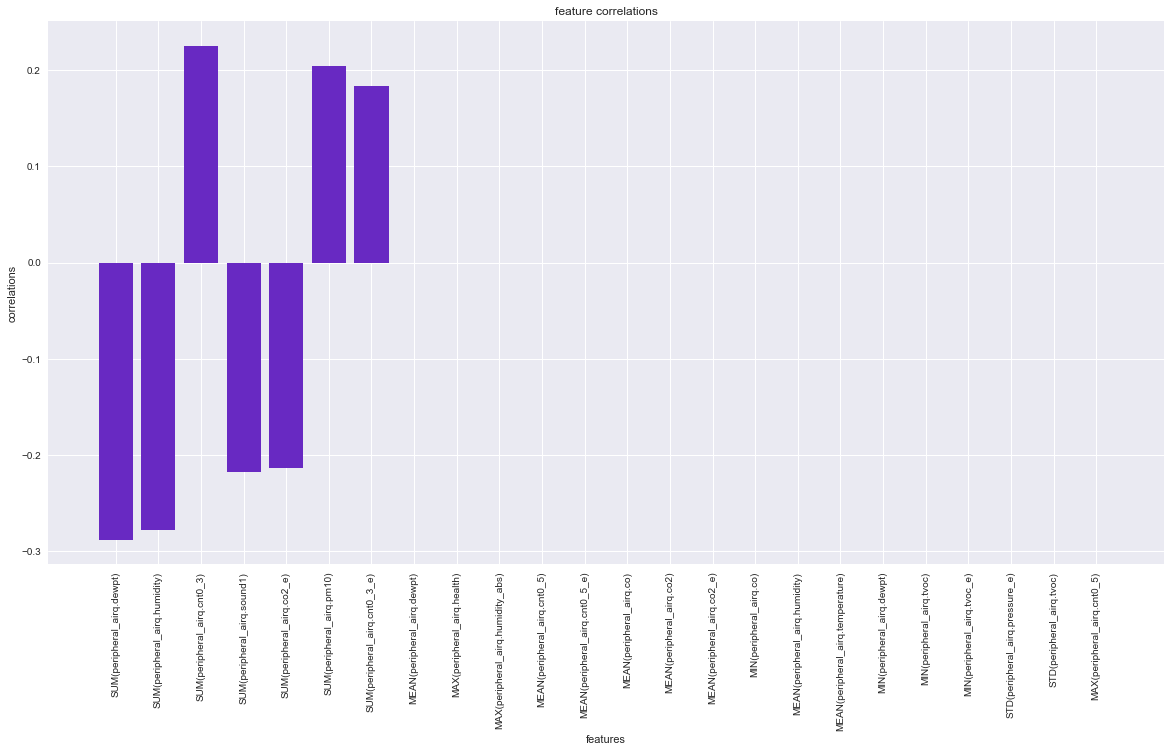

In [91]:
names, correlations = pipe_featuretools.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

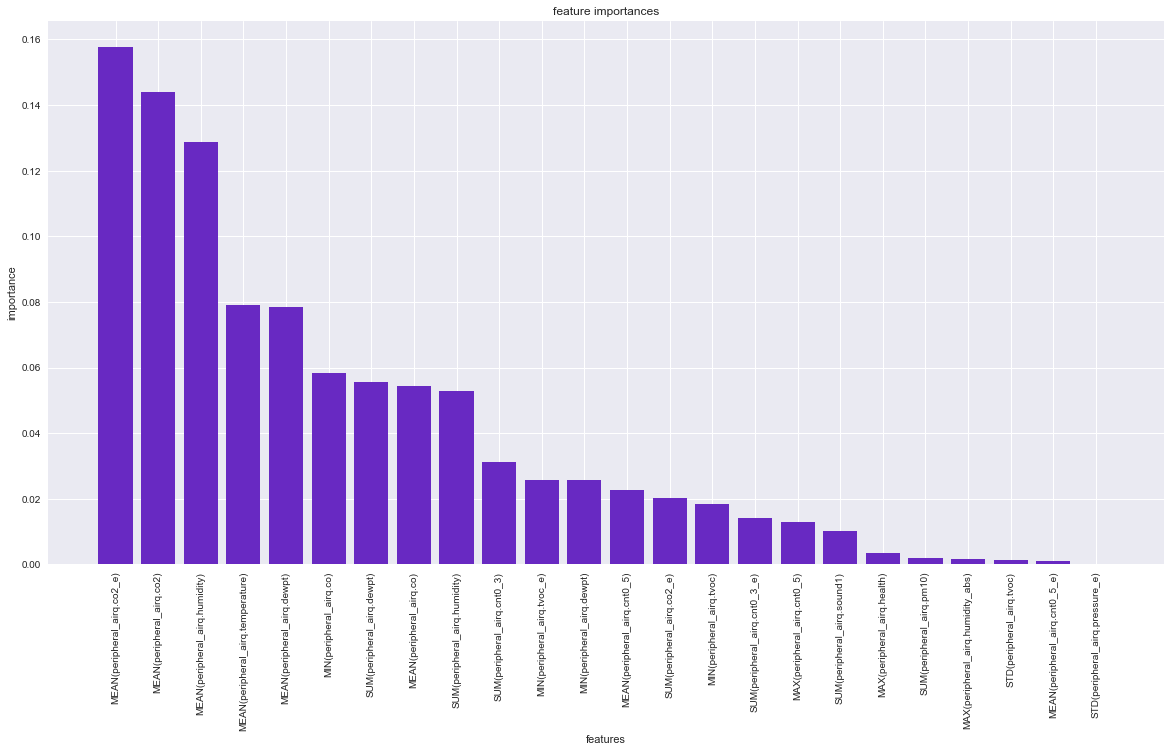

24

In [92]:
names, importances = pipe_featuretools.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

len(names)

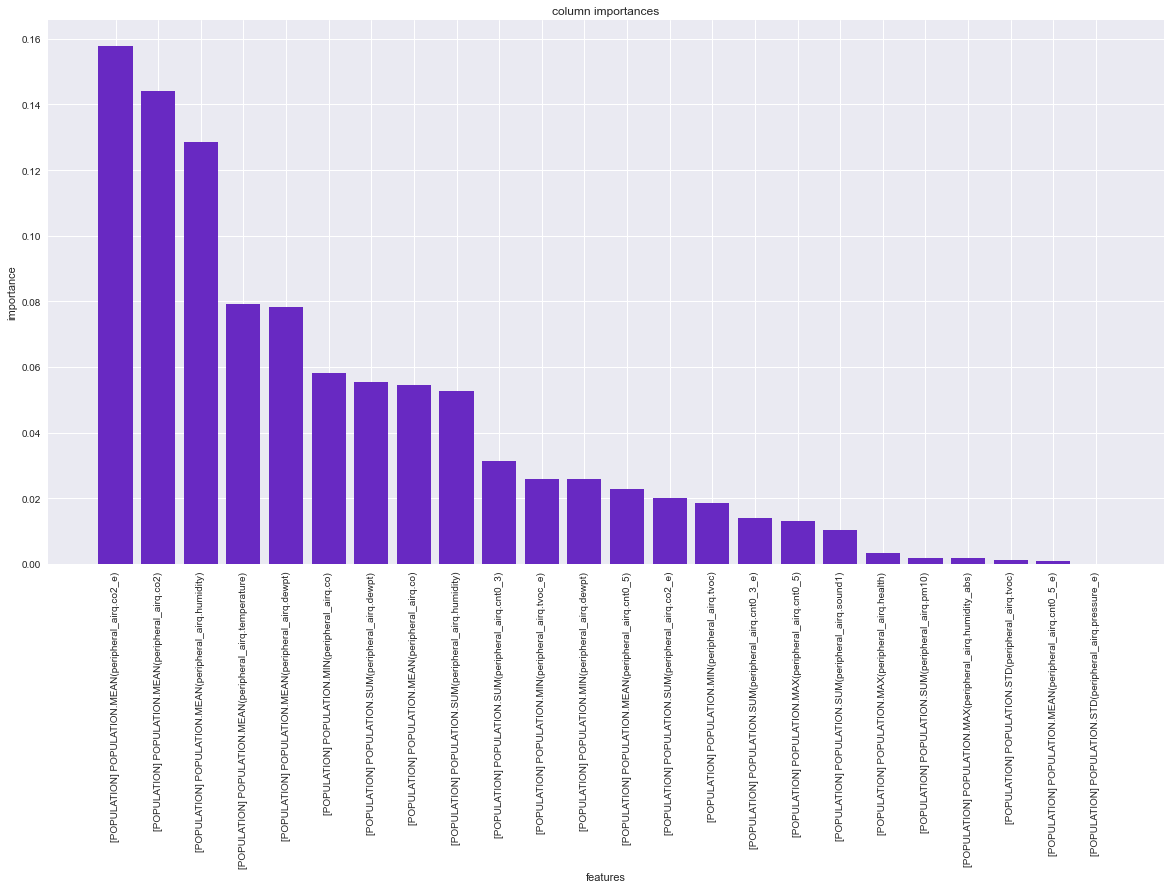

24

In [93]:
names, importances = pipe_featuretools.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

len(names)

In [94]:
pipe_featuretools.features.to_sql()

```sql
DROP TABLE IF EXISTS "FEATURES";

CREATE TABLE "FEATURES" AS
SELECT CAST( t1."occupancy" AS REAL ) AS "target_1__occupancy",
       CAST( t1."MAX(peripheral_airq.cnt0_5)" AS REAL ) AS "manual_feature_1__MAX(peripheral_airq.cnt0_5)",
       CAST( t1."MAX(peripheral_airq.health)" AS REAL ) AS "manual_feature_2__MAX(peripheral_airq.health)",
       CAST( t1."MAX(peripheral_airq.humidity_abs)" AS REAL ) AS "manual_feature_3__MAX(peripheral_airq.humidity_abs)",
       CAST( t1."MEAN(peripheral_airq.cnt0_5)" AS REAL ) AS "manual_feature_4__MEAN(peripheral_airq.cnt0_5)",
       CAST( t1."MEAN(peripheral_airq.cnt0_5_e)" AS REAL ) AS "manual_feature_5__MEAN(peripheral_airq.cnt0_5_e)",
       CAST( t1."MEAN(peripheral_airq.co)" AS REAL ) AS "manual_feature_6__MEAN(peripheral_airq.co)",
       CAST( t1."MEAN(peripheral_airq.co2)" AS REAL ) AS "manual_feature_7__MEAN(peripheral_airq.co2)",
       CAST( t1."MEAN(peripheral_airq.co2_e)" AS REAL ) AS "manual_feature_8__MEAN(peripheral_airq.co2_e)",
       CAST( t1."MEAN(peripheral_airq.dewpt)" AS REAL ) AS "manual_feature_9__MEAN(peripheral_airq.dewpt)",
       CAST( t1."MEAN(peripheral_airq.humidity)" AS REAL ) AS "manual_feature_10__MEAN(peripheral_airq.humidity)",
       CAST( t1."MEAN(peripheral_airq.temperature)" AS REAL ) AS "manual_feature_11__MEAN(peripheral_airq.temperature)",
       CAST( t1."MIN(peripheral_airq.co)" AS REAL ) AS "manual_feature_12__MIN(peripheral_airq.co)",
       CAST( t1."MIN(peripheral_airq.dewpt)" AS REAL ) AS "manual_feature_13__MIN(peripheral_airq.dewpt)",
       CAST( t1."MIN(peripheral_airq.tvoc)" AS REAL ) AS "manual_feature_14__MIN(peripheral_airq.tvoc)",
       CAST( t1."MIN(peripheral_airq.tvoc_e)" AS REAL ) AS "manual_feature_15__MIN(peripheral_airq.tvoc_e)",
       CAST( t1."STD(peripheral_airq.pressure_e)" AS REAL ) AS "manual_feature_16__STD(peripheral_airq.pressure_e)",
       CAST( t1."STD(peripheral_airq.tvoc)" AS REAL ) AS "manual_feature_17__STD(peripheral_airq.tvoc)",
       CAST( t1."SUM(peripheral_airq.cnt0_3)" AS REAL ) AS "manual_feature_18__SUM(peripheral_airq.cnt0_3)",
       CAST( t1."SUM(peripheral_airq.cnt0_3_e)" AS REAL ) AS "manual_feature_19__SUM(peripheral_airq.cnt0_3_e)",
       CAST( t1."SUM(peripheral_airq.co2_e)" AS REAL ) AS "manual_feature_20__SUM(peripheral_airq.co2_e)",
       CAST( t1."SUM(peripheral_airq.dewpt)" AS REAL ) AS "manual_feature_21__SUM(peripheral_airq.dewpt)",
       CAST( t1."SUM(peripheral_airq.humidity)" AS REAL ) AS "manual_feature_22__SUM(peripheral_airq.humidity)",
       CAST( t1."SUM(peripheral_airq.pm10)" AS REAL ) AS "manual_feature_23__SUM(peripheral_airq.pm10)",
       CAST( t1."SUM(peripheral_airq.sound1)" AS REAL ) AS "manual_feature_24__SUM(peripheral_airq.sound1)"
FROM "POPULATION" t1
ORDER BY t1.rowid;


```

In [95]:
fpr_f, tpr_f = pipe_featuretools.metrics.roc_curve()

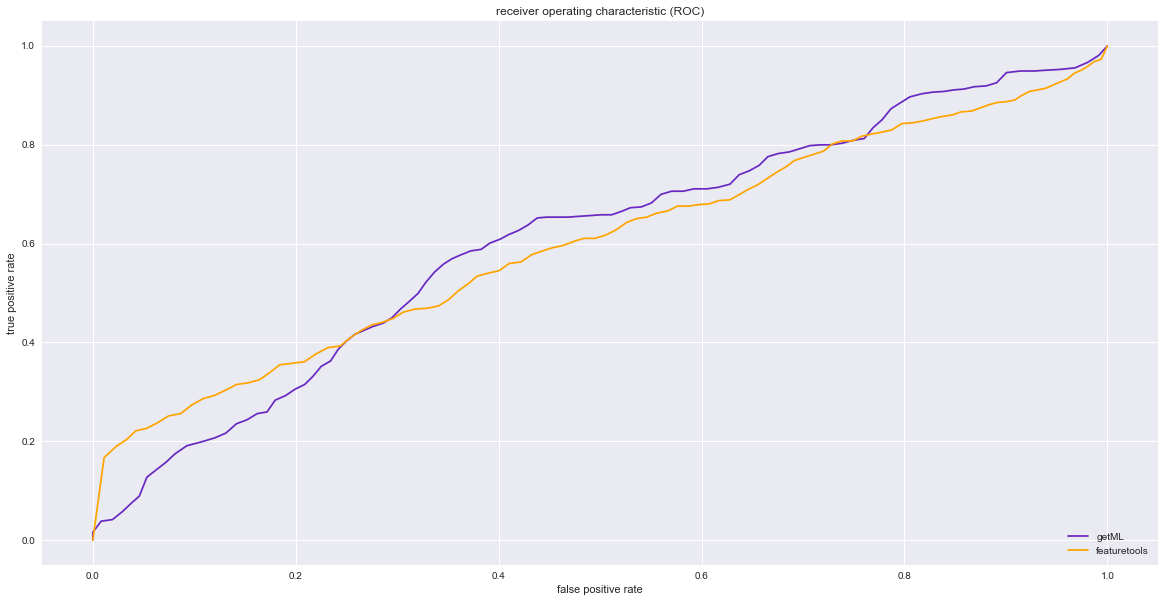

In [96]:
# Refers to the data from the last time
# we called .score(...).
fpr_g, tpr_g = pipe.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_g, tpr_g, color='#6829c2', label="getML")
plt.plot(fpr_f, tpr_f, color='orange', label="featuretools")

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")

plt.show()